In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.metrics import accuracy_score,roc_auc_score
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
import pickle

from sklearn.model_selection import GridSearchCV,cross_validate   

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

In [3]:
#putlocker scraper takes approximately 5 minutes-> max to complete on local runtime
def scrape_putlocker():
  genre_pages_links=[]
  movie_titles=[]#
  watch_links=[]
  movie_ids=[]
  genres=[]#done
  try:
    url='https://w5.putlocker.to/movies'
    content=requests.get(url).text
    web_soup=BeautifulSoup(content,"html.parser")
    for page_link in web_soup.find('ul',class_='sub-menu').find_all('a'):
      genre_pages_links.append(page_link['href'])
    id_=0
    #generalization for whole website
    for link in genre_pages_links:
      #test code for 1 genre
      genre_link=link
      content=requests.get(genre_link).text
      genre_soup=BeautifulSoup(content,"html.parser")
      if genre_soup.find('nav') is not None:
        int_of_last_page=int(genre_soup.find('nav').find_all('a')[-1]['href'].split('/page/')[1])
        pages_required_per_genre=10
        for page_count in range(pages_required_per_genre+1):
          page_url=genre_soup.find('nav').find_all('a')[-1]['href'].split('/page/')[0]+'/page/{}'.format(page_count)
          content=requests.get(page_url).text
          page_soup=BeautifulSoup(content,"html.parser")
          #code for each page
          for div_ in page_soup.find_all('div',class_='ml-item'):
            genre_=genre_link.split('/genre/')[1]
            title_=div_.find('h2').text
            watch_link_=div_.find('a')['href']
            #append movie data to lists
            genres.append(genre_)
            movie_titles.append(title_)
            watch_links.append(watch_link_)  
            movie_ids.append(id_) 
            id_=id_+1        
      else:
        pass
    putlocker_data={
          "movie_id":movie_ids,
          "title":movie_titles,
          "genre":genres,
          "watch_link":watch_links 
    }
    putlocker_df=pd.DataFrame(putlocker_data)
    putlocker_df.drop_duplicates(subset='title',keep='last',inplace=False)
    #putlocker_df.head(10)
    #write to csv
    putlocker_df.to_csv('putlocker_movies.csv',index=False)
    !cp putlocker_movies.csv "AI_development_and_evaluation"
    return putlocker_df
  except:
    with open('putlocker_movies.csv','r') as f:
      try:
        putlocker_df=pd.read_csv(f)
      except:
        pass
  return putlocker_df

In [4]:
#create dataset
def create_main_dataset(putlocker_dataframe):
  putlocker_df=putlocker_dataframe
  #putlocker_df.shape
  user_ratings_df=pd.read_csv('user_ratings.csv')
  #user_ratings_df.shape
  #each user should be represented in the whole dataframe
  users=4
  required_size=(len(putlocker_df)*users)+1
  user_ratings_df=user_ratings_df.iloc[0:required_size,:]
  #replace values per section
  x=pd.Series()
  x=x.append(pd.Series(np.array(putlocker_df['movie_id'])),ignore_index=True)
  x=x.append(pd.Series(np.array(putlocker_df['movie_id'])),ignore_index=True)
  x=x.append(pd.Series(np.array(putlocker_df['movie_id'])),ignore_index=True)
  x=x.append(pd.Series(np.array(putlocker_df['movie_id'])),ignore_index=True)
  x=x.rename('movie_id')


  #adjust user ids
  list_of_users=['user1','user2','user3','user4']
  y=user_ratings_df['user_id']
  y.iloc[0:len(putlocker_df)]=list_of_users[0]
  y.iloc[len(putlocker_df)+1:len(putlocker_df)*2]=list_of_users[1]
  y.iloc[(len(putlocker_df)*2)+1:(len(putlocker_df)*3)]=list_of_users[2]
  y.iloc[(len(putlocker_df)*3)+1:(len(putlocker_df)*4)]=list_of_users[3]
  y=y.rename('user_id')

  newdf=pd.concat([x,y], axis=1)
  #adding the new dataframe
  user_ratings_df=user_ratings_df.drop('movie_id',axis=1)
  user_ratings_df=user_ratings_df.drop('user_id',axis=1)
  user_ratings_df=user_ratings_df.join(newdf)
  user_ratings_df=user_ratings_df.loc[:,'movie_id':].join(pd.DataFrame(user_ratings_df.loc[:,'user_rating']))

  user_ratings_df.to_csv('adjusted_user_ratings.csv',index=None)
  user_ratings_df=pd.read_csv('adjusted_user_ratings.csv')
  user_ratings_df.tail()

  #merge the movies and ratings dataframes
  dataset_df=putlocker_df.merge(user_ratings_df,on='movie_id',how='left')
  dataset_df.info(verbose=False,memory_usage='deep')
  dataset_df.to_csv('main_dataset.csv',index=None)
  dataset_df=pd.read_csv('main_dataset.csv',dtype={'user_rating':'int8','genre':'category','title':'category'})  
  print('DATASET SAVED <main_dataset.csv>')
  return dataset_df

In [5]:
#scrape data
putlocker_df=pd.DataFrame()
putlocker_df=scrape_putlocker()
putlocker_df.shape

(8379, 4)

In [6]:
putlocker_df['title'].replace({
    "\”":'',
    "\.":'',
    "\'":'',
    '()':'',
    "\(":'',
    "\)":'',
    "\[":'',
    "\]":'',
    ':':'',
    '#':'',
    "\*":'_',
    '-':'_',
    "\"":'',
    ' ':'_',
    ',':'',
    '!':'',
    '“':'',
    '&':'and',
    '3':'Three',
    '–':'_',
    "\'":'',
    '__':'_'
     },regex=True,inplace=True)
putlocker_df=putlocker_df[~(putlocker_df.title =='¡Three_Amigos')]
putlocker_df=putlocker_df[~(putlocker_df.title =='Ölümlü_Dünya')]
putlocker_df=putlocker_df[~(putlocker_df.title =='Ænigma_Lucio_Fulci_and_the_80s')]
putlocker_df=putlocker_df[~(putlocker_df.title =="\'71")]
putlocker_df['genre'].replace({'-':'_'},regex=True,inplace=True)
putlocker_df.shape

(8373, 4)

In [7]:
putlocker_df

,movie_id,title,genre,watch_link
0,0,Jumanji_The_Next_Level,action,https://w5.putlocker.to/79105-watch-jumanji-th...
1,1,Black_and_Blue,action,https://w5.putlocker.to/79096-watch-black-and-...
2,2,Terminator_Dark_Fate,action,https://w5.putlocker.to/79097-watch-terminator...
3,3,Zombieland_Double_Tap,action,https://w5.putlocker.to/79086-watch-zombieland...
4,4,Gemini_Man,action,https://w5.putlocker.to/78834-watch-gemini-man...
...,...,...,...,...
8374,8374,The_Stand_at_Apache_River,western,https://w5.putlocker.to/1053-watch-the-stand-a...
8375,8375,Gun_Fury,western,https://w5.putlocker.to/1050-watch-gun-fury-on...
8376,8376,Those_Redheads_from_Seattle,western,https://w5.putlocker.to/1040-watch-those-redhe...
8377,8377,Powder_River,western,https://w5.putlocker.to/1038-watch-powder-rive...


In [8]:
#create dataframe
dataset_df=create_main_dataset(putlocker_df)
#total of ratings
pd.DataFrame(dataset_df.groupby('title')['user_rating'].sum()).rename(columns={'user_rating':'total_of_ratings'})

<ipython-input-4-40ac91bcf0f6>:12: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  x=pd.Series()
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 33492 entries, 0 to 33491
Columns: 6 entries, movie_id to user_rating
dtypes: int64(2), object(4)
memory usage: 11.8 MB
DATASET SAVED <main_dataset.csv>


,total_of_ratings
title,
10000_Saints,18.0
100_Things,19.0
12_Strong,37.0
12_Suicidal_Teens,28.0
12_Years_a_Slave,17.0
...,...
Zorro,52.0
Zorro_The_Gay_Blade,17.0
mother,13.0


In [9]:
dataset_df.head()

,movie_id,title,genre,watch_link,user_id,user_rating
0,0,Jumanji_The_Next_Level,action,https://w5.putlocker.to/79105-watch-jumanji-th...,user1,3
1,0,Jumanji_The_Next_Level,action,https://w5.putlocker.to/79105-watch-jumanji-th...,290,1
2,0,Jumanji_The_Next_Level,action,https://w5.putlocker.to/79105-watch-jumanji-th...,345,3
3,0,Jumanji_The_Next_Level,action,https://w5.putlocker.to/79105-watch-jumanji-th...,506,2
4,1,Black_and_Blue,action,https://w5.putlocker.to/79096-watch-black-and-...,user1,3


In [10]:

dataset_df['genre'].unique()

['action', 'adventure', 'animation', 'comedy', 'crime', ..., 'romance', 'science_fiction', 'thriller', 'war', 'western']
Length: 20
Categories (20, object): ['action', 'adventure', 'animation', 'comedy', ..., 'science_fiction', 'thriller', 'war', 'western']

In [11]:
totals_df=pd.DataFrame(dataset_df.groupby('title')['user_rating'].sum()).rename(columns={'user_rating':'sum_of_ratings'})
totals_df=totals_df.merge((dataset_df.groupby('title')['user_id'].count()).rename('num_of_ratings'), on='title')
movie_ratings_sr=pd.Series(totals_df['sum_of_ratings']/totals_df['num_of_ratings']).rename('movie_rating')
totals_df=totals_df.merge(movie_ratings_sr,on='title')
dataset_df=dataset_df.merge(totals_df,on='title').drop(['sum_of_ratings','num_of_ratings','user_id','user_rating'],axis=1)
dataset_df.to_csv('main_movie_ratings.csv',index=False)
dataset_df

,movie_id,title,genre,watch_link,movie_rating
0,0,Jumanji_The_Next_Level,action,https://w5.putlocker.to/79105-watch-jumanji-th...,3.50
1,0,Jumanji_The_Next_Level,action,https://w5.putlocker.to/79105-watch-jumanji-th...,3.50
2,0,Jumanji_The_Next_Level,action,https://w5.putlocker.to/79105-watch-jumanji-th...,3.50
3,0,Jumanji_The_Next_Level,action,https://w5.putlocker.to/79105-watch-jumanji-th...,3.50
4,40,Jumanji_The_Next_Level,action,https://w5.putlocker.to/79105-watch-jumanji-th...,3.50
...,...,...,...,...,...
33487,8377,Powder_River,western,https://w5.putlocker.to/1038-watch-powder-rive...,2.75
33488,8378,The_Man_from_the_Alamo,western,https://w5.putlocker.to/1037-watch-the-man-fro...,2.50
33489,8378,The_Man_from_the_Alamo,western,https://w5.putlocker.to/1037-watch-the-man-fro...,2.50
33490,8378,The_Man_from_the_Alamo,western,https://w5.putlocker.to/1037-watch-the-man-fro...,2.50


In [12]:
#using movie_ratings
x=dataset_df.drop_duplicates(subset='title',keep='last',inplace=False)

In [13]:
dataset=x.reset_index().drop(['index','movie_id'],axis=1)
dataset.head()

,title,genre,watch_link,movie_rating
0,Jumanji_The_Next_Level,featured,https://w5.putlocker.to/79105-watch-jumanji-th...,3.50000
1,Black_and_Blue,featured,https://w5.putlocker.to/79096-watch-black-and-...,3.87500
2,Terminator_Dark_Fate,science_fiction,https://w5.putlocker.to/79097-watch-terminator...,3.50000
3,Zombieland_Double_Tap,horror,https://w5.putlocker.to/79086-watch-zombieland...,3.65625
4,Gemini_Man,thriller,https://w5.putlocker.to/78834-watch-gemini-man...,3.68750


In [14]:
dataset=dataset.sample(frac=0.5, replace=True, random_state=1)
dataset=dataset.drop('watch_link',axis=1)

In [15]:
dataset.dtypes

title           category
genre           category
movie_rating     float64
dtype: object

In [16]:
#split the data
X=dataset.iloc[:,:-1]
y=pd.DataFrame(dataset.iloc[:,-1])

In [17]:
X.head()

,title,genre
5157,Rough_Night_in_Jericho,western
235,The_Witch_Part_1_The_Subversion,mystery
3980,Black_Snow,mystery
5192,The_Comancheros,western
905,Storks,animation


In [18]:
#test code for y label encoder and X encoder
encoded_X=pd.get_dummies(X, prefix=['title', 'genre'])
label_encoded_y=y.apply(LabelEncoder().fit_transform)

In [19]:
label_encoded_y.head()

,movie_rating
5157,19
235,58
3980,19
5192,54
905,44


In [20]:
avg_rating=float(label_encoded_y.mean())
label_encoded_y.loc[ label_encoded_y['movie_rating'] < avg_rating,'movie_rating' ]=0
label_encoded_y.loc[ label_encoded_y['movie_rating'] > avg_rating,'movie_rating' ]=1
label_encoded_y.head()

,movie_rating
5157,0
235,1
3980,0
5192,1
905,1


In [21]:
#split into train and test data
X_train, X_test, y_train, y_test = train_test_split(encoded_X, np.ravel(np.array(label_encoded_y)), test_size=0.2,random_state=50)

In [22]:
#use of optimixed data structure dataset_dmatrix
dtrain_=xgb.DMatrix(X_train,label= y_train)
dtest_=xgb.DMatrix(X_test,label= y_test)

## CREATING MODEL

In [23]:
from sklearn.metrics import roc_auc_score
#for zero divides
np.seterr( divide='ignore',invalid='ignore')
# fit model on all training data
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)
# make predictions for test data and evaluate
preds = xgb_model.predict(X_test)
# get the rmse and mape of train data
rmse =  np.sqrt(mean_squared_error(y_test,preds))
accuracy = accuracy_score(y_test, preds)
auc=roc_auc_score(y_test,preds)
# store the results in train_results dictionary
test_results = {'predictions' : preds,'rmse': rmse,'accuracy' : (accuracy*100) ,'AUC ':(auc*100)}

/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:13:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [24]:
# fit model on all training data
model_ = xgb.XGBClassifier(
    learning_rate =0.001,
    n_estimators=140,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.2,
    colsample_bytree=0.1,
    reg_alpha=0.005,
    objective= 'binary:logistic',
    nthread=1,
    scale_pos_weight=1,
    seed=27
    )

# regularization parameters ambda, alpha
#lower learning rate and decide optimal parameters
model_.fit(X_train, y_train)
# make predictions for test data and evaluate
y_pred = model_.predict(X_test)
# get the rmse and mape of train data
rmse_m =  np.sqrt(mean_squared_error(y_test,y_pred))
#accuracy_m=float( np.sum(y_pred==y_test) )/y_test.shape[0]
accuracy = accuracy_score(y_test, y_pred)
auc_m=roc_auc_score(y_test, y_pred)
# store the results in train_results dictionary
pickle.dump(model_, open("test_0.pkl", "wb"))
loaded_model = pickle.load(open("test_0.pkl", "rb"))
test_results = {'predictions' : y_pred,'rmse': rmse_m,'Accuracy' : (accuracy*100) ,'AUC' :auc }

/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:15:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


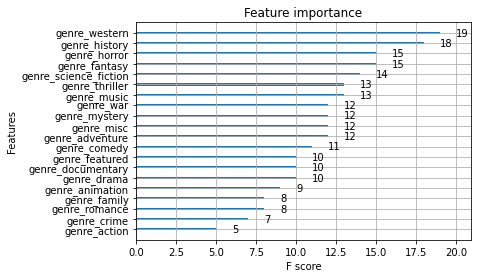

In [25]:
# plot feature importance
xgb.plot_importance(model_)
plt.show()

In [26]:
thresholds= np.sort(model_.feature_importances_)
init_accuracy=0.0
for val in thresholds:
  # use of F score as threshold for a single feature
  from sklearn.feature_selection import SelectFromModel
  # select features using threshold
  selection = SelectFromModel(model_, threshold=val, prefit=True)
  select_X_train = selection.transform(X_train)
  # train model
  selection_model = loaded_model
  selection_model.fit(select_X_train, y_train)
  # eval model
  select_X_test = selection.transform(X_test)
  y_pred = selection_model.predict(select_X_test)
  predictions = [round(value) for value in y_pred]
  accuracy = accuracy_score(y_test, predictions)
  if accuracy > init_accuracy:
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (val, select_X_train.shape[1],accuracy*100))
    init_accuracy=accuracy
  else:
    break


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:15:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=5277, Accuracy: 51.52%


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:16:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
#lower learning rate
xgb_model_ = xgb.XGBClassifier(
      objective="binary:logistic",
      learning_rate=0.1,
      n_estimators=1000,
      max_depth=5,
      min_child_weight=0,
      gamma=0,
      subsample=0.8,
      colsample_bytree=0.8,
      nthread=4,
      scale_pos_weight=1,
      seed=27,
      reg_alpha=0 )
xgb_model_.fit(select_X_train, y_train)
y_pred_ = xgb_model_.predict(select_X_test)
predictions_ = [round(value) for value in y_pred_]
accuracy = accuracy_score(y_test, predictions_)
print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (val, select_X_train.shape[1],accuracy*100))

/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:38:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
pickle.dump(xgb_model_ , open("model.pkl", "wb"))
loaded_model = pickle.load(open("model.pkl", "rb"))